In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["image.cmap"] = "gray"

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## 1 Load and Split MNIST Dataset

In [4]:
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

X_valid = X_train_all[:10000]
X_train = X_train_all[10000:]

y_valid = y_train_all[:10000]
y_train = y_train_all[10000:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


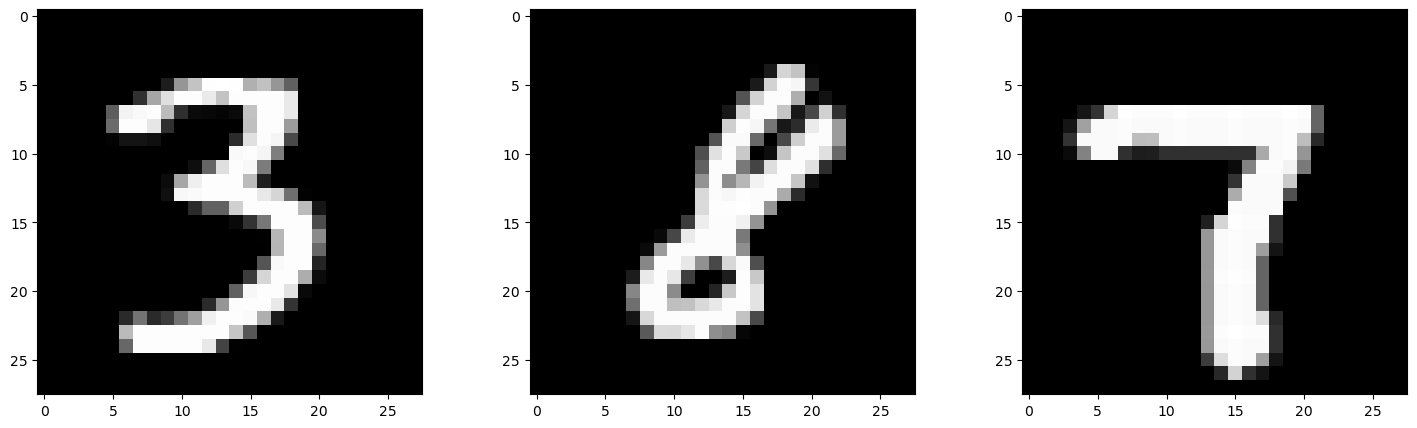

In [5]:
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis(True)
    plt.imshow(X_train[i], cmap="gray")
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

## 2 Data Preprocessing

How to represent image data as features -- pixel intensities are the features
28 x 28 input image becomes 1D array with 784 features, each feature has a pixel intensity in the range of 0-1
This is a naive approach -- CNNs have more complex ways for representing image data

In [6]:
# change data shape to have 784 features
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
# change feature value to range from 0-1
X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
X_valid = X_valid.astype("float32") / 255

### Integer Encoding

In [7]:
# Load Fashion MNIST dataset
((X_train_fashion, y_train_fashion), (_, _)) = fashion_mnist.load_data()

# The labels in the dataset are encoded as integers
print(y_train_fashion[0:9])

[9 0 0 3 0 2 7 2 5]


### One-Hot Label Encoding

In [8]:
# Use to_categorical function in Keras to convert each label to a binary vector where 
# the length of the vector is equal to the number of classes
# All entries are zero except for the element that corresponds to integer label - similar to dummy coding
y_train_onehot = to_categorical(y_train_fashion[0:9])
print(y_train_onehot)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [9]:
# Convert integer labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

## 3 Model Architecture 

### 3.1 Deep Neural Network Architecture

The network architecture shown below has multiple layers. An input layer, two hidden layers, and an output layer. There are several things to note about this architecture.

1. **Input Data**: The image input data is pre-processed (flattened) from a 2-Dimensional array `[28x28]` to 1-Dimensional vector of length `[784x1]` where the elements in this input vector are the normalized pixel intensities. The input to the network is sometimes referred to as the input "layer", but it's not technically a layer in the network because there are no trainable parameters associated with it.
2. **Hidden Layers**: We have two hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc...).
3. **Output Layer**: We now have ten neurons in the output layer to represent the ten different classes (digits: 0 to 9), instead of a single neuron as in the regression example.
4. **Dense Layers**: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The **weights** associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.
5. **Softmax Function**: The values from each of the neurons in the output layer are pased through a **softmax** function to produce a probability score for each of the ten digits in the dataset. 

6. **Network Output**: The network output ($y’$), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing ($y'$) through the `argmax` function to determine the index of the predicted label.
6. **Loss Function**: The loss function used is **Cross Entropy Loss**, which is generally the preferred loss function for classification problems. It is computed from the ground truth labels ($y$) and the output probabilities of the network ($y'$). Note that $y$ and $y'$ are both vectors whose length is equal to the number of classes.

Although the diagram looks quite a bit different from the single-layer perceptron in the linear regression example, it is fundamentally very similar in terms of the processing that takes place during training and prediction. We still compute a loss based on the predicted output of the network and the ground truth label of the inputs. Backpropagation is used to compute the gradient of the loss with respect to the weights in the network. An optimizer (which implements gradient descent) is used to update the weights in the neural network.

## 4 Model Implementation

Here we use Keras to define the model architecture, which has two dense layers (each with 128 neurons) and a single output layer with 10 neurons. Each neuron in the output layer corresponds to a class label from the dataset (0 through 9) where the output of each represents the probability that the input image corresponds to the class associated with that neuron. For example, if the output from the 5th neuron is .87, then that means the probability that the input image is a 4 is 87% (since the first class is 0, the 5th neuron represents the digit `4`). 

Notice that the first hidden layer has an input shape of [784,1] since the 28x28 image is flattened to a vector of length 784. The neurons in each of the hidden layers have activation functions called "ReLU" which stands for Rectified Linear Unit. The neurons in the output layer are then passed through a "softmax" function which transforms (normalizes) the raw output, which can be interpreted as a probability as described above.

We will not cover the details of the softmax function or the cross entropy loss function in this post as these are more advanced topics and will be deferred to a post, but briefly, the softmax function normalizes the outputs from the network and converts them to probabilities. The cross-entropy loss function computes a loss between the predicted output probabilities and the ground truth labels. The further the predicted output probabilities are from the target labels the higher the loss. 


### Define the Model

In [10]:
# Instatiate the model
model = tf.keras.Sequential()

# Build the model
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

This step defines the optimizer and the loss function that will be used in the training loop. This is also where we can specify any additional metrics to track.

**Optimizer**: Here, we will use the RMSProp optimizer in Keras.

**Loss Function**: As mentioned above, the preferred loss function for classification problems is **Cross Entropy**. But depending on how the labels are encoded we’ll need to specify the proper form of the cross entropy loss function. If the labels are one-hot encoded, then you should specify the loss function as `categorical_crossentropy`, and if the labels are integer encoded, then you should use `sparse_categorical_crossentropy`. When performing binary classification, you should use `binary_crossentropy` as the loss function. Since we are using one-hot encoding in this example, we will specify the loss function as `categorical_crossentropy`. 

**Metrics**: Finally, we also specify `accuracy` as an additional metric to record during training so that we can plot it after training is completed. The training loss and validation loss are automatically recorded, so there is no need to specify those.

In [11]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### 4.3 Train the Model
To train the model we call the `fit()` method in Keras. Notice that since we split the original training data into train and validation components, we need to explicitly specify the validation dataset using `validation_data=(X_valid, y_valid))`. Recall from an ealier post in this series on linear regression, that we also have the option to use the `validation_split` argument to automatically withhold a random portion of the training data for use as the validation data. So here, we're demonstrating how to explicitly use a separate validation dataset. 

In [12]:
training_results = model.fit(X_train,
                             y_train,
                             epochs=21,
                             batch_size=64,
                             validation_data=(X_valid, y_valid));

Epoch 1/21
782/782 [==============================] - 2s 2ms/step - loss: 2.4458 - accuracy: 0.8677 - val_loss: 2.1712 - val_accuracy: 0.8448
Epoch 2/21
782/782 [==============================] - 2s 2ms/step - loss: 0.5330 - accuracy: 0.9316 - val_loss: 2.1888 - val_accuracy: 0.6739
Epoch 3/21
782/782 [==============================] - 2s 2ms/step - loss: 0.3110 - accuracy: 0.9464 - val_loss: 2.2080 - val_accuracy: 0.4069
Epoch 4/21
782/782 [==============================] - 2s 2ms/step - loss: 0.2188 - accuracy: 0.9561 - val_loss: 2.2068 - val_accuracy: 0.1889
Epoch 5/21
782/782 [==============================] - 2s 3ms/step - loss: 0.1817 - accuracy: 0.9618 - val_loss: 2.2036 - val_accuracy: 0.1770
Epoch 6/21
782/782 [==============================] - 2s 3ms/step - loss: 0.1651 - accuracy: 0.9652 - val_loss: 2.1992 - val_accuracy: 0.1770
Epoch 7/21
782/782 [==============================] - 2s 2ms/step - loss: 0.1599 - accuracy: 0.9686 - val_loss: 2.2209 - val_accuracy: 0.1365
Epoch 

### Plot the Training Results

In [13]:
# Use plot_results function for plotting training and validation losses/accuracies
# It's single argument is which metrics to plot
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fix, ax = plt.subplots(figsize=(15,4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
    
    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0,20])
    plt.ylim(ylim)
    # Tailor x=axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

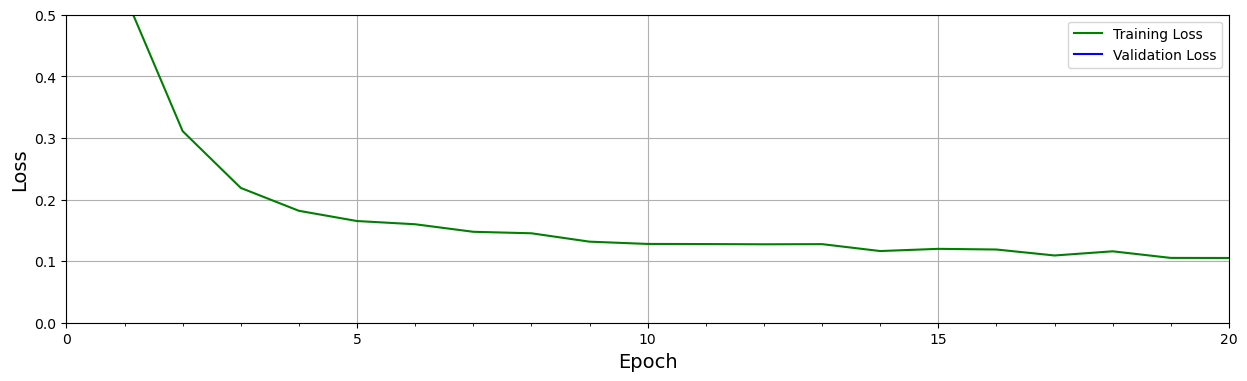

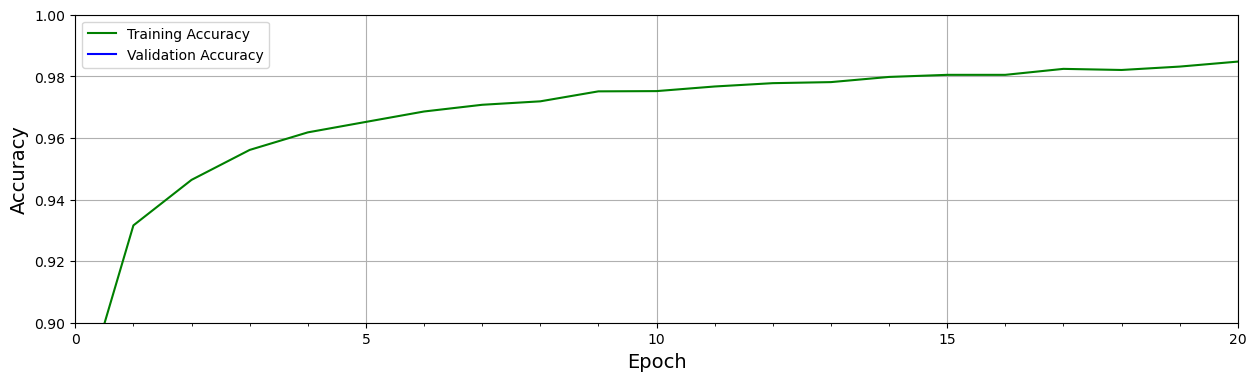

In [14]:
# Retrieve training results from history object from fit method
train_loss = training_results.history["loss"]
train_acc = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc = training_results.history["val_accuracy"]

plot_results(
    [train_loss,valid_loss],
    ylabel="Loss",
    ylim=[0.0, 0.5],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"]
)

plot_results(
    [train_acc,valid_acc],
    ylabel="Accuracy",
    ylim=[0.9, 1],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"]
)

## 5 Model Evaluation

Make prediciton on sample test images

In [15]:
predictions = model.predict(X_test)
index = 0
print("Ground truth for test digit: ", y_test[index])
print("\n")
print("Predictions for each class:\n")
for i in range(10):
    print("digit", i, " probability: ", predictions[index][i])

313/313 [==============================] - 0s 1ms/step
Ground truth for test digit:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Predictions for each class:

digit 0  probability:  0.0
digit 1  probability:  0.0
digit 2  probability:  1.3308691e-36
digit 3  probability:  0.0
digit 4  probability:  0.0
digit 5  probability:  0.0
digit 6  probability:  0.0
digit 7  probability:  1.0
digit 8  probability:  0.0
digit 9  probability:  1.7994908e-33


### Confusion Matrix

Generate in TensorFlow iwth function tf.math.confusion_matrix() - two arguments: lsit of ground truth labels and associated predicted labels

In [16]:
# Generate predictions for test dataset
predictions = model.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 0s 1ms/step


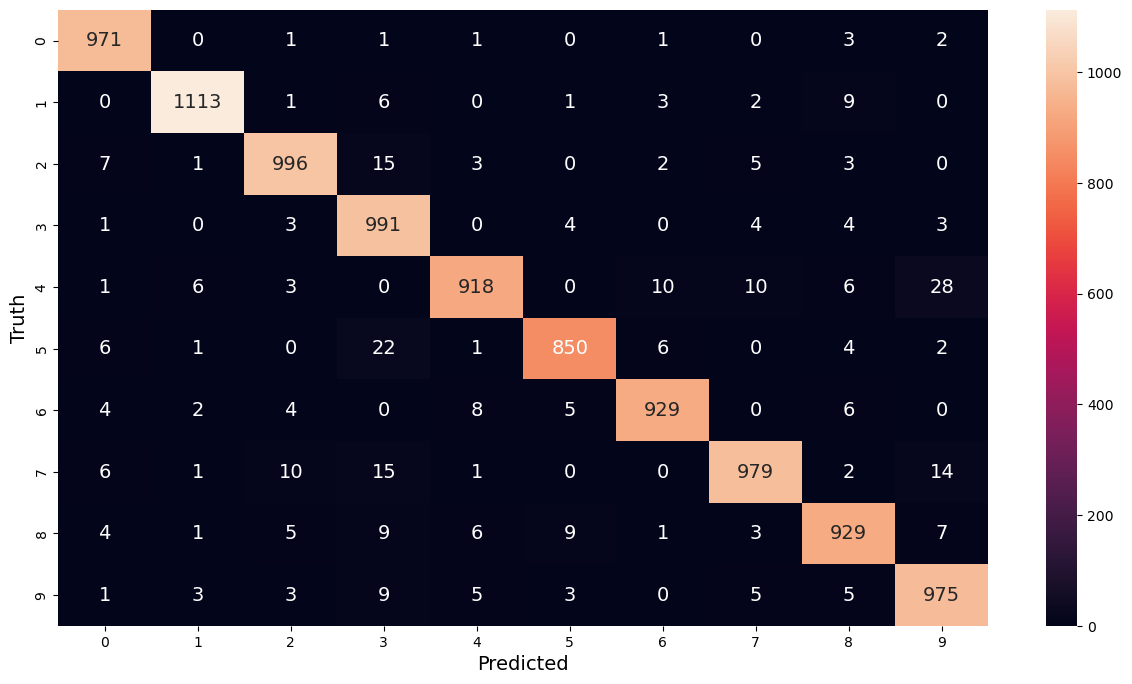

In [17]:
# Convert one-hot coded labels to integers
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion omatrix as a heatmap
plt.figure(figsize=[15,8])
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()